In [1]:
import numpy as np
from torch import Tensor
from src.datasets.shakespeare.shakespeare import ShakespeareDataset
from torch.nn import functional as F
from src.training.discrete_loss import (
    #alpha_variance_loss,
    divergence_loss,
    format_loss,
    loss,
    variance_loss,
)

In [2]:
import os

import torch
from accelerate import Accelerator
from matplotlib import pyplot as plt
from safetensors.torch import load_file
from tqdm.auto import tqdm

from src.datasets.collate_fn import collate_fn_maker
from src.datasets.shakespeare.shakespeare import ShakespeareDataset
from src.inference.discrete_inference import bayesian_inference, dis_t
from src.nn.layers.learnable_schedule import LearnableBetaScheduleNI
from src.nn.models.discrete_model import DiscreteModel
from src.tokenizers.byt5.byt5_tokenizer import ByT5Tokenizer as Tokenizer
from src.training.checkpoint import CheckpointManager, CheckpointMetadata
from src.training.training import train_discrete_model

# we use accelerator on CPU since this is not a training run and we don't want to run
# into issues with GPU memory while we are debugging in this notebook
accelerator = Accelerator(project_dir="./runs/shakespeare", cpu=True)
tokenizer = Tokenizer()
max_seq_len = 168
folds = 8
dataset = ShakespeareDataset(
    tokenizer=tokenizer, max_length=max_seq_len, folds=folds,
)

model_kwargs = {
    "max_seq_len": max_seq_len,
    "K": tokenizer.vocab_size(),
    "hidden_dim": 512,
    "num_heads": 8,
    "layers": 5,
    # beta_1 from https://arxiv.org/html/2407.20294v2 equation 5
    "reference_beta_1": 20.4054 / tokenizer.vocab_size(),
    "learner_weight": 1.0,
    "freeze_body": False,
    "fourier_schedule": False,
}
model = DiscreteModel(**model_kwargs)

optimizer_kwargs = {
    "lr": 3e-5,
}
body_opt = torch.optim.Adam(
    model.body.parameters(), **optimizer_kwargs  # pyright: ignore[reportArgumentType]
)
schedule_opt = torch.optim.Adam(
    model.learnable_beta.parameters(),
    **optimizer_kwargs,  # pyright: ignore[reportArgumentType]
)

metadata = CheckpointMetadata(
    model_kwargs=model_kwargs,
    optimizer_kwargs=optimizer_kwargs,
    is_fsdp=hasattr(accelerator.state, "fsdp_plugin")
    and accelerator.state.fsdp_plugin is not None,
    num_accelerators=accelerator.num_processes,
)

checkpoint_dir = "./checkpoint/shakespeare_byt5_learnt_shift"
checkpoint_manager = CheckpointManager()
print("Preparing model...")
checkpoint_manager.prepare(model, body_opt, schedule_opt, accelerator, metadata)
print("Starting checkpoint loading process...")
checkpoint_manager.load(checkpoint_dir, error_if_not_exists=True)
print("Finished loading checkpoint")

model, opt = checkpoint_manager.model, checkpoint_manager.body_optimizer

assert model is not None
assert isinstance(model, DiscreteModel)

schedule: LearnableBetaScheduleNI = model.learnable_beta

assert isinstance(schedule, LearnableBetaScheduleNI)

Using the latest cached version of the module from /media/john/Tertiary/Data/huggingface/modules/datasets_modules/datasets/karpathy--tiny_shakespeare/b5b13969f09fe8707337f6cb296314fbe06960bd9a868dca39e713e163d27b5e (last modified on Sun Jul 20 14:43:33 2025) since it couldn't be found locally at karpathy/tiny_shakespeare, or remotely on the Hugging Face Hub.


Preparing model...
Starting checkpoint loading process...
Attempting to load checkpoint from epoch 212786
Finished loading checkpoint


In [3]:
collate_fn = collate_fn_maker(
    tokenizer=tokenizer, max_masks=3, min_masks=1, max_fill=0.95, min_fill=0.05
)

In [4]:
for param in model.parameters():
    is_nan_or_inf = torch.isnan(param).any() or torch.isinf(param).any()
    if is_nan_or_inf:
        raise ValueError("Model parameters contain NaN or Inf values.")

In [5]:
device = accelerator.device

Learnt beta_1: 0.0205, Scaling: 0.0010, Alpha std: 0.0000


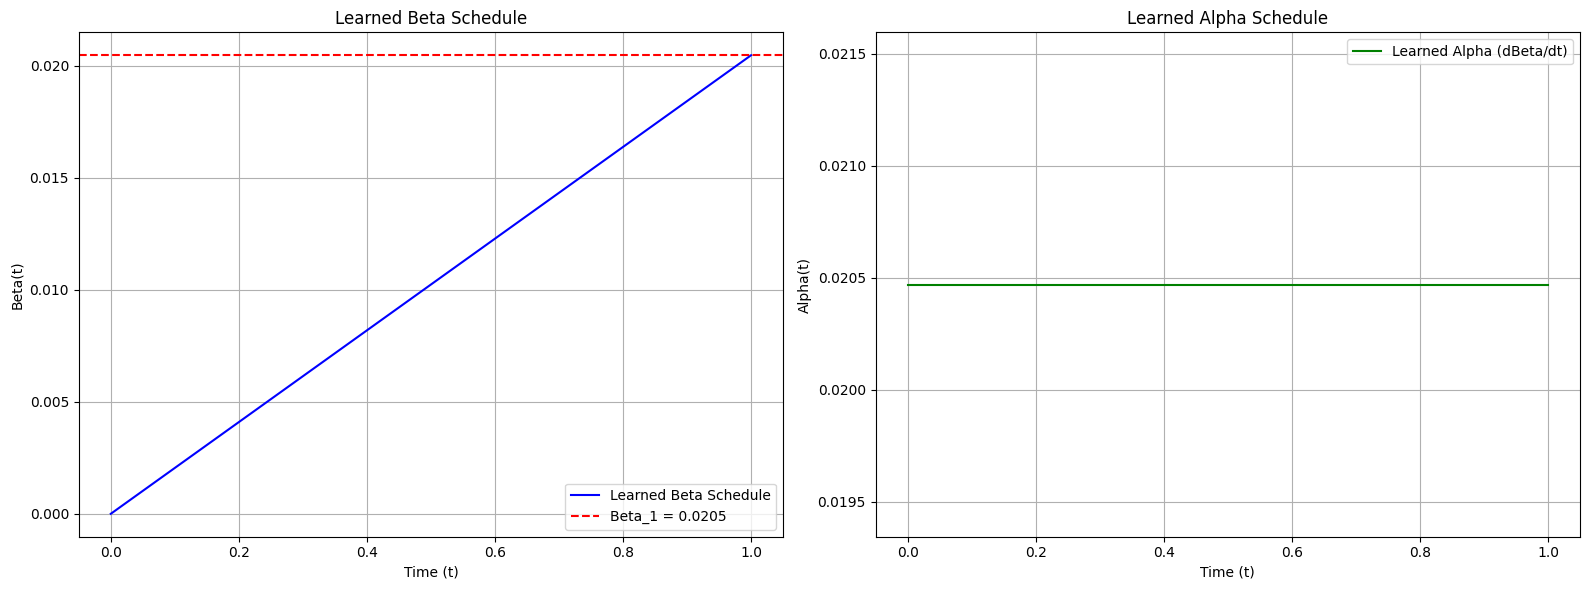

In [6]:
beta_scheduler = model.learnable_beta
t_coords, beta_coords = beta_scheduler.visualize(K=tokenizer.vocab_size(), points=150, device=device)
alpha_t_coords, alpha_coords = beta_scheduler.visualize_alpha(K=tokenizer.vocab_size(), points=150, device=device)
learnt_beta_1 = model.beta_1(K=tokenizer.vocab_size(), device=device)
scaling = model.scaling(tokenizer.vocab_size(), device=device)

print(f"Learnt beta_1: {learnt_beta_1:.4f}, Scaling: {scaling:.4f}, Alpha std: {np.std(alpha_coords):.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Beta schedule
ax1.plot(t_coords, beta_coords, label='Learned Beta Schedule', color='blue')
ax1.axhline(y=learnt_beta_1, color='red', linestyle='--', label=f'Beta_1 = {learnt_beta_1:.4f}')
ax1.set_xlabel('Time (t)')
ax1.set_ylabel('Beta(t)')
ax1.set_title('Learned Beta Schedule')
ax1.legend()
ax1.grid(True)

# Alpha schedule
ax2.plot(alpha_t_coords, alpha_coords, label='Learned Alpha (dBeta/dt)', color='green')
ax2.set_xlabel('Time (t)')
ax2.set_ylabel('Alpha(t)')
ax2.set_title('Learned Alpha Schedule')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

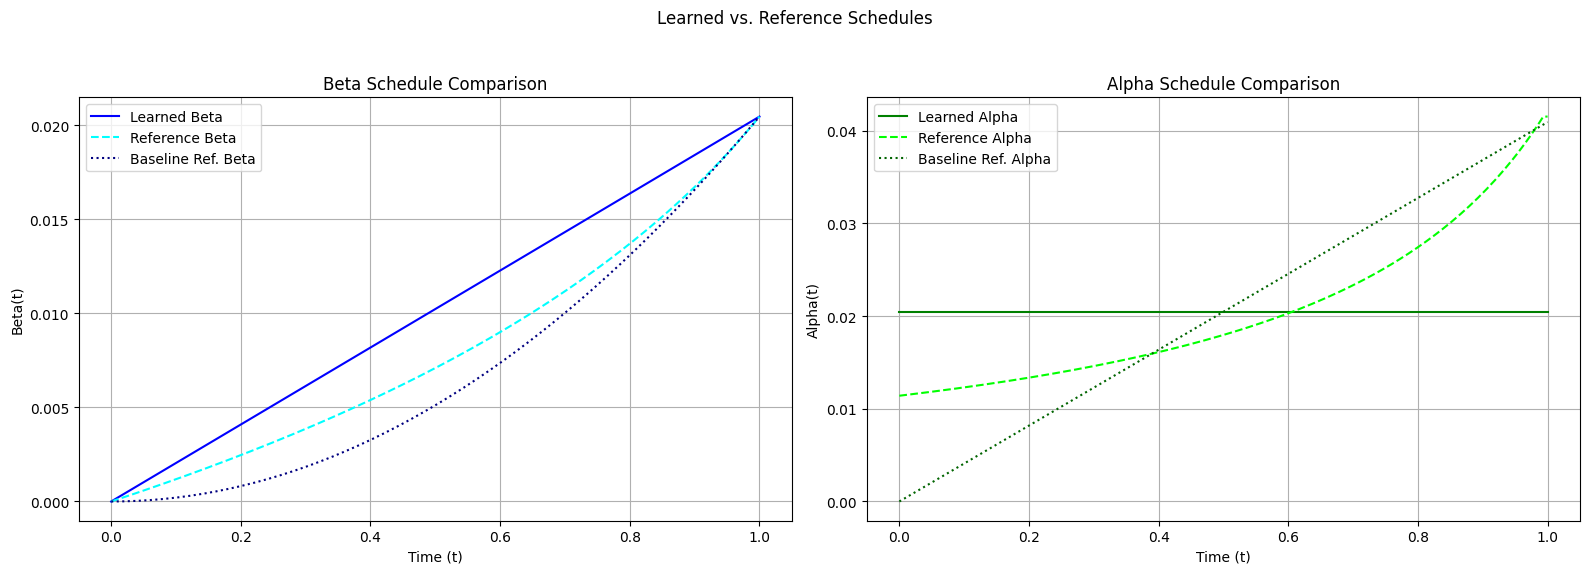

In [7]:
# from chem bfn paper
def reference_beta_schedule(t: Tensor, K: int, beta_1: float) -> Tensor:
    return (- 4 / K) * torch.log(1 - t + t * torch.exp(- K * beta_1 / 4))
def reference_alpha_schedule(t: Tensor, K: int, beta_1: float) -> Tensor:
    return (4 / K) * ((1 - torch.exp(-K * beta_1 / 4)) / (1 - t + t * torch.exp(-K * beta_1 / 4)))

# from original bfn paper
def reference_beta_schedule_baseline(t: Tensor, K: int, beta_1: float) -> Tensor:
    return beta_1 * (t ** 2)
def reference_alpha_schedule_baseline(t: Tensor, K: int, beta_1: float) -> Tensor:
    return beta_1 * 2 * t

ref_beta = reference_beta_schedule(torch.as_tensor(t_coords), tokenizer.vocab_size(), torch.tensor([learnt_beta_1]))
ref_alpha = reference_alpha_schedule(torch.as_tensor(alpha_t_coords), tokenizer.vocab_size(), torch.tensor([learnt_beta_1]))
ref_alpha[-1] = ref_alpha[-2]  # avoid tiny numerical issues at t=1, the graph looks useless otherwise
ref_beta_baseline = reference_beta_schedule_baseline(torch.as_tensor(t_coords), tokenizer.vocab_size(), torch.tensor([learnt_beta_1]))
ref_alpha_baseline = reference_alpha_schedule_baseline(torch.as_tensor(alpha_t_coords), tokenizer.vocab_size(), torch.tensor([learnt_beta_1]))
# t_coords, beta_coords, ref_beta
# alpha_t_coords, alpha_coords, ref_alpha
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Learned vs. Reference Schedules')

# Beta schedule comparison
ax1.plot(t_coords, beta_coords, label='Learned Beta', color='blue')
ax1.plot(t_coords, ref_beta.numpy(), label='Reference Beta', color='cyan', linestyle='--')
ax1.plot(t_coords, ref_beta_baseline.numpy(), label='Baseline Ref. Beta', color='navy', linestyle=':')
ax1.set_xlabel('Time (t)')
ax1.set_ylabel('Beta(t)')
ax1.set_title('Beta Schedule Comparison')
ax1.legend()
ax1.grid(True)

# Alpha schedule comparison
ax2.plot(alpha_t_coords, alpha_coords, label='Learned Alpha', color='green')
ax2.plot(alpha_t_coords, ref_alpha.numpy(), label='Reference Alpha', color='lime', linestyle='--')
ax2.plot(alpha_t_coords, ref_alpha_baseline.numpy(), label='Baseline Ref. Alpha', color='darkgreen', linestyle=':')
ax2.set_xlabel('Time (t)')
ax2.set_ylabel('Alpha(t)')
ax2.set_title('Alpha Schedule Comparison')
ax2.legend()
ax2.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

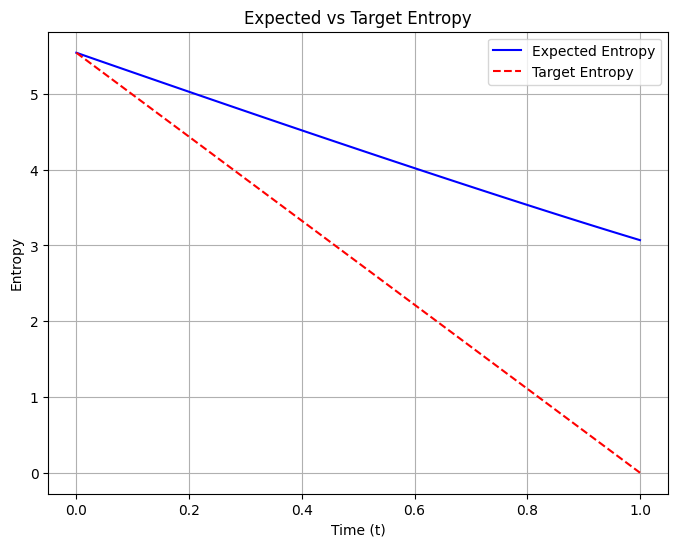

MSE is 3.075717


In [8]:
from math import log
from torch.distributions import Categorical
from src.datasets.discrete_helper import y_distribution

with torch.no_grad():
    # here we take a random sample from the dataset and see what the entropy of the perturbed version is
    sample = dataset[0]
    sampled_x = sample["x"].unsqueeze(0).to(device)  # Add batch
    sampled_x = F.one_hot(sampled_x, num_classes=tokenizer.vocab_size())
    
    t_coords = torch.linspace(0, 1, 100, device=device)
    
    K = tokenizer.vocab_size()
    
    beta_t = schedule(t_coords, K)
    beta_t_dist = y_distribution(beta_t, K, sampled_x, deterministic=False)
    beta_cat = Categorical(logits=beta_t_dist)
    
    entropy = beta_cat.entropy()
    seq_expected_entropy = torch.mean(entropy, dim=-1)
    
    target_entropy = log(K) * (1 - t_coords)

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(t_coords.cpu().numpy(), seq_expected_entropy.cpu().numpy(), label='Expected Entropy', color='blue')
    ax.plot(t_coords.cpu().numpy(), target_entropy.cpu().numpy(), label='Target Entropy', color='red', linestyle='--')
    ax.set_xlabel('Time (t)')
    ax.set_ylabel('Entropy')
    ax.set_title('Expected vs Target Entropy')
    ax.legend()
    ax.grid(True)
    plt.show()

print(f"MSE is {(seq_expected_entropy - target_entropy).pow(2).mean():.6f}")

Variance of losses: 0.6230, Standard Deviation: 0.7893


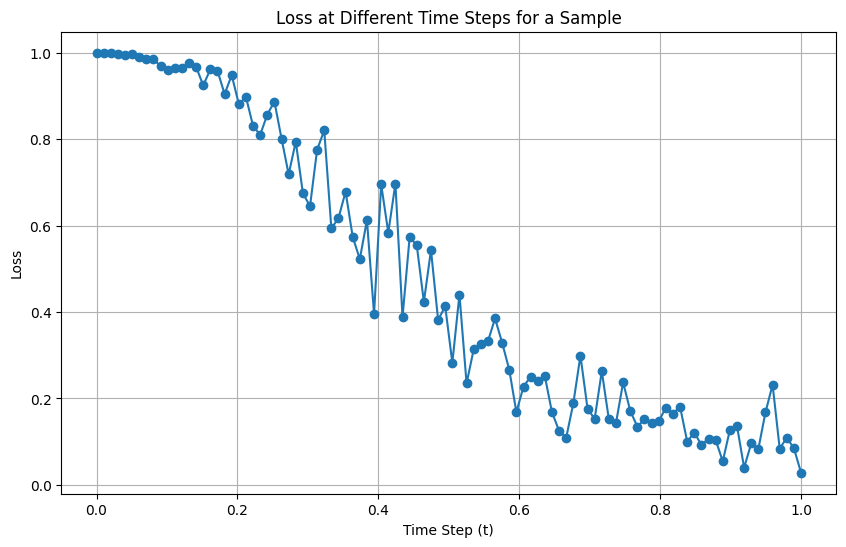

In [9]:
# with torch.no_grad():
# here we take a random sample from the dataset and repeat it on different time steps to see if the loss is uniform at each time step
sample = dataset[0]
collated = collate_fn([sample])
enc = collated["encoder_input"]
sampled_x = collated["target"]
enc = enc.to(device)
sampled_x = sampled_x.to(device)
sampled_t = torch.linspace(0, 1, 100).to(device) + 1e-8 # Add 100 time steps, prevent 0 using small epsilon
sampled_losses = []
for t in sampled_t:
    sample_output, sample_alpha = model.forward(enc,sampled_x, t.unsqueeze(0))
    # Calculate loss for each time step
    formatted_loss = format_loss(
                sample_alpha, sampled_x, model_output_logits=sample_output, folds=1
    )
    sample_loss = loss(formatted_loss)
    sampled_losses.append(sample_loss.cpu().item())
sampled_losses = np.array(sampled_losses)

print(
    f"Variance of losses: {np.var(sampled_losses):.4f}, Standard Deviation: {np.std(sampled_losses):.4f}"
)

sampled_losses = sampled_losses / sampled_losses.max()
plt.figure(figsize=(10, 6))
plt.plot(sampled_t.cpu().detach().numpy(), sampled_losses, marker='o', linestyle='-')
plt.xlabel('Time Step (t)')
plt.ylabel('Loss')
plt.title('Loss at Different Time Steps for a Sample')
plt.grid(True)
plt.show()

In [10]:
# # Lets define a helpful benchmarking function:
# import torch.utils.benchmark as benchmark
# import torch
# from torch.nn import functional as F
# def benchmark_torch_function_in_microseconds(f, *args, **kwargs):
#     t0 = benchmark.Timer(
#         stmt="f(*args, **kwargs)", globals={"args": args, "kwargs": kwargs, "f": f}
#     )
#     return t0.blocked_autorange().mean * 1e6

# # Lets define the hyper-parameters of our input
# batch_size = 32
# max_sequence_len = 1024
# num_heads = 32
# embed_dimension = 32
# device = "cuda" if torch.cuda.is_available() else "cpu"

# dtype = torch.float16

# query = torch.rand(batch_size, num_heads, max_sequence_len, embed_dimension, device=device, dtype=dtype)
# key = torch.rand(batch_size, num_heads, max_sequence_len, embed_dimension, device=device, dtype=dtype)
# value = torch.rand(batch_size, num_heads, max_sequence_len, embed_dimension, device=device, dtype=dtype)

# print(f"The default implementation runs in {benchmark_torch_function_in_microseconds(F.scaled_dot_product_attention, query, key, value):.3f} microseconds")

# # Lets explore the speed of each of the 3 implementations
# from torch.nn.attention import SDPBackend, sdpa_kernel


# with sdpa_kernel(SDPBackend.MATH):
#     math_time=benchmark_torch_function_in_microseconds(F.scaled_dot_product_attention, query, key, value)
#     print(f"The math implementation runs in {math_time:.3f} microseconds")

# with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
#     try:
#         flash_time=benchmark_torch_function_in_microseconds(F.scaled_dot_product_attention, query, key, value)
#         print(f"The flash attention implementation runs in {flash_time:.3f} microseconds")
#     except RuntimeError:
#         print("FlashAttention is not supported. See warnings for reasons.")

# with sdpa_kernel(SDPBackend.EFFICIENT_ATTENTION):
#     try:
#         efficient_time=benchmark_torch_function_in_microseconds(F.scaled_dot_product_attention, query, key, value)
#         print(f"The memory efficient implementation runs in {efficient_time:.3f} microseconds")
#     except RuntimeError:
#         print("EfficientAttention is not supported. See warnings for reasons.")

# The default implementation runs in 5508.405 microseconds
# <timeit-src>:6: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:310.)
# The math implementation runs in 58766.464 microseconds
# The flash attention implementation runs in 5515.071 microseconds
# The memory efficient implementation runs in 5512.375 microseconds

In [11]:
# torch inductor compiler failure:
# AssertionError: expected size 128==128, stride 1040==1280 at dim=0; expected size 8==8, stride 130==160 at dim=1; expected size 130==160, stride 1==1 at dim=2

In [12]:
# Training Discrete Model:   0%|                                                                                          | 0/1300000 [00:33<?, ?it/s]
# Traceback (most recent call last):
#   File "/media/john/Tertiary/Projects/ML/BayesianFlowNet/train_script.py", line 123, in <module>
#     train_discrete_model(
#   File "/media/john/Tertiary/Projects/ML/BayesianFlowNet/src/training/training.py", line 115, in train_discrete_model
#     accelerator.backward(l)
#   File "/media/john/Tertiary/Projects/ML/BayesianFlowNet/.venv/lib/python3.11/site-packages/accelerate/accelerator.py", line 2246, in backward
#     loss.backward(**kwargs)
#   File "/media/john/Tertiary/Projects/ML/BayesianFlowNet/.venv/lib/python3.11/site-packages/torch/_tensor.py", line 626, in backward
#     torch.autograd.backward(
#   File "/media/john/Tertiary/Projects/ML/BayesianFlowNet/.venv/lib/python3.11/site-packages/torch/autograd/__init__.py", line 347, in backward
#     _engine_run_backward(
#   File "/media/john/Tertiary/Projects/ML/BayesianFlowNet/.venv/lib/python3.11/site-packages/torch/autograd/graph.py", line 823, in _engine_run_backward
#     return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
#            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#   File "/media/john/Tertiary/Projects/ML/BayesianFlowNet/.venv/lib/python3.11/site-packages/torch/autograd/function.py", line 307, in apply
#     return user_fn(self, *args)
#            ^^^^^^^^^^^^^^^^^^^^
#   File "/media/john/Tertiary/Projects/ML/BayesianFlowNet/.venv/lib/python3.11/site-packages/torch/_functorch/_aot_autograd/runtime_wrappers.py", line 1710, in backward
#     return impl_fn()
#            ^^^^^^^^^
#   File "/media/john/Tertiary/Projects/ML/BayesianFlowNet/.venv/lib/python3.11/site-packages/torch/_functorch/_aot_autograd/runtime_wrappers.py", line 1700, in impl_fn
#     out = CompiledFunction._backward_impl(ctx, all_args)
#           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#   File "/media/john/Tertiary/Projects/ML/BayesianFlowNet/.venv/lib/python3.11/site-packages/torch/_functorch/_aot_autograd/runtime_wrappers.py", line 2065, in _backward_impl
#     out = call_func_at_runtime_with_args(
#           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#   File "/media/john/Tertiary/Projects/ML/BayesianFlowNet/.venv/lib/python3.11/site-packages/torch/_functorch/_aot_autograd/utils.py", line 126, in call_func_at_runtime_with_args
#     out = normalize_as_list(f(args))
#                             ^^^^^^^
#   File "/media/john/Tertiary/Projects/ML/BayesianFlowNet/.venv/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py", line 745, in _fn
#     return fn(*args, **kwargs)
#            ^^^^^^^^^^^^^^^^^^^
#   File "/media/john/Tertiary/Projects/ML/BayesianFlowNet/.venv/lib/python3.11/site-packages/torch/_inductor/output_code.py", line 466, in __call__
#     return self.current_callable(inputs)
#            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#   File "/media/john/Tertiary/Projects/ML/BayesianFlowNet/.venv/lib/python3.11/site-packages/torch/_inductor/utils.py", line 2128, in run
#     return model(new_inputs)
#            ^^^^^^^^^^^^^^^^^
#   File "/tmp/torchinductor_john/6u/c6uxdifd4aeowbx6u3nn3hws5vkmmdy4wwo5kt65rrgmzu3sqpyt.py", line 1726, in call
#     assert_size_stride(getitem_1, (128, 8, 160), (1280, 160, 1))
# AssertionError: expected size 128==128, stride 1040==1280 at dim=0; expected size 8==8, stride 130==160 at dim=1; expected size 130==160, stride 1==1 at dim=2
# Traceback (most recent call last):
#   File "/media/john/Tertiary/Projects/ML/BayesianFlowNet/.venv/bin/accelerate", line 8, in <module>
#     sys.exit(main())
#              ^^^^^^
#   File "/media/john/Tertiary/Projects/ML/BayesianFlowNet/.venv/lib/python3.11/site-packages/accelerate/commands/accelerate_cli.py", line 48, in main
#     args.func(args)
#   File "/media/john/Tertiary/Projects/ML/BayesianFlowNet/.venv/lib/python3.11/site-packages/accelerate/commands/launch.py", line 1172, in launch_command
#     simple_launcher(args)
#   File "/media/john/Tertiary/Projects/ML/BayesianFlowNet/.venv/lib/python3.11/site-packages/accelerate/commands/launch.py", line 762, in simple_launcher
#     raise subprocess.CalledProcessError(returncode=process.returncode, cmd=cmd)
# subprocess.CalledProcessError: Command '['/media/john/Tertiary/Projects/ML/BayesianFlowNet/.venv/bin/python3.11', 'train_script.py']' returned non-zero exit status 1.